In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
# !rm ~/.cache/matplotlib -rf

## Distance Metrics

When would we use Distance Metrics?

The most intuitive one
* Euclidean distance: 
    + Generalization: Minkowski distance (Norm 1: Manhattan distance)
    + but can be problematic

Problem 1: Does not count relativity between variables
* Cosine Distance

Problem 2: Variables may correlate with each other.
* Mahalanobis distance

Other distance metric:
* Jaccard distance


To devise a clustering methods, we need to 
* Step 1: define a distance metric between objects $d(x_1, x_2)$
* Step 2: define an objective function (clustering goal)
* Step 3: optimize the objective function by updating parameters



## Problem: Clustering of Digit Images (0-9) 

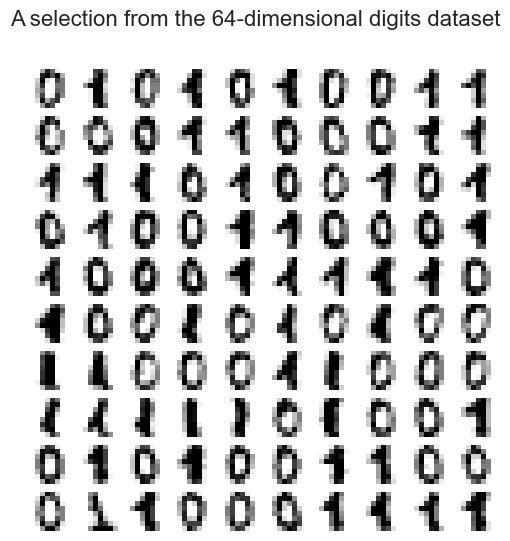

In [20]:
digit_zero=pd.read_csv("data/digitData0.csv",header=None)
digit_one=pd.read_csv("data/digitData1.csv",header=None)

# merge two files
df=pd.concat([digit_zero,digit_one],join="inner")
df.columns=["feature_"+str(i+1) for i in range(df.shape[1]-1)] + ["target"]

# we only select digits 0, 1
examples = df.to_numpy()
df['target'] = df['target'].astype(int)
df_selected = df[(df.target==0) | (df.target==1)]

examples = df_selected.to_numpy()

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    example = examples[idx, :]
    ax.imshow(example[:64].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)
plt.show()

# split features and labels
X=df_selected.iloc[:,:-1]
y=df_selected.iloc[:,-1]


## K means
* Centroids - Clusters of data points
* What are parameteers of a K-means model?

The scikit-learn API requies that:
* The data is represented by NumPy array or pandas DataFrame with features in columns and observations in rows.
* The features take on continuous values as opposed to the categories.
* No missing values

In [21]:
## Generate synthetic dataset with 8 random clusters
model = KMeans(n_clusters=2)
y_pred=model.fit_predict(X)


Let's evaluate the model.

[[  0 320]
 [323   4]]


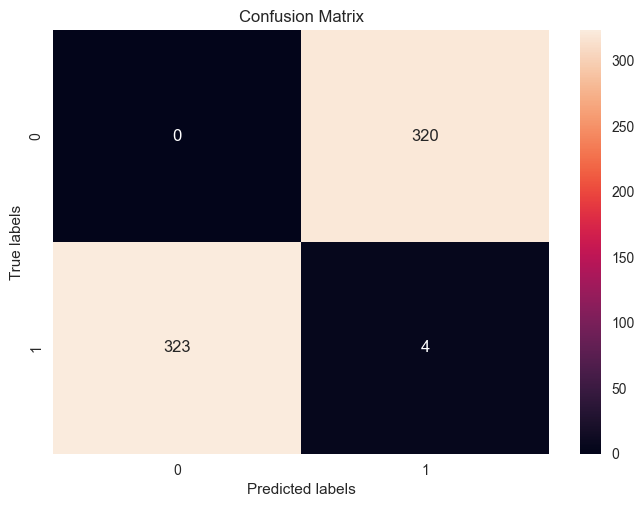

In [13]:
# compute confusion matrix
contingency_matrix = metrics.cluster.contingency_matrix(y, y_pred)
print(contingency_matrix)

# visualize
ax= plt.subplot()
sns.heatmap(contingency_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

In [13]:
# precision: how many examples are correctly predicted during all predictions for a target
# recall: how many examples are correctly predicted during all examples of one class
# F1 = 2 * (precision * recall) / (precision + recall)
print(metrics.classification_report(y, y_pred, labels=[0, 1], target_names=["zero","one"]))

              precision    recall  f1-score   support

        zero       0.99      1.00      0.99       320
         one       1.00      0.99      0.99       327

    accuracy                           0.99       647
   macro avg       0.99      0.99      0.99       647
weighted avg       0.99      0.99      0.99       647



In [16]:
# purity: note that we assume that we match the predicted label with the ground truth by `amax`
correct_predictions = np.amax(contingency_matrix, axis=0)
score =  np.sum(correct_predictions) / np.sum(contingency_matrix) 

print(
    "purity_score: %0.3f"
    % purity_score(y, y_pred)
)

# Mutual Information

# Silhouette Coefficient

Let's determine the hyperparameter K assuming that we do not know that $X$ contains features for 2 digits.

In [22]:
# Method 1
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for n_clusters in range_n_clusters:
    model = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = model.fit_predict(X)

    # The silhouette_score gives the average value for all the samples. This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    # sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)


For n_clusters = 2 The average silhouette_score is : 0.3746565097054628
For n_clusters = 3 The average silhouette_score is : 0.4018987106389799
For n_clusters = 4 The average silhouette_score is : 0.4263604139629081
For n_clusters = 5 The average silhouette_score is : 0.2447212838409384
For n_clusters = 6 The average silhouette_score is : 0.2022214417666319
For n_clusters = 7 The average silhouette_score is : 0.18682935613298354
For n_clusters = 8 The average silhouette_score is : 0.19397197471105912
For n_clusters = 9 The average silhouette_score is : 0.1795855767035055
For n_clusters = 10 The average silhouette_score is : 0.17989119376853246
For n_clusters = 11 The average silhouette_score is : 0.18138840879641385
For n_clusters = 12 The average silhouette_score is : 0.17996046848389904


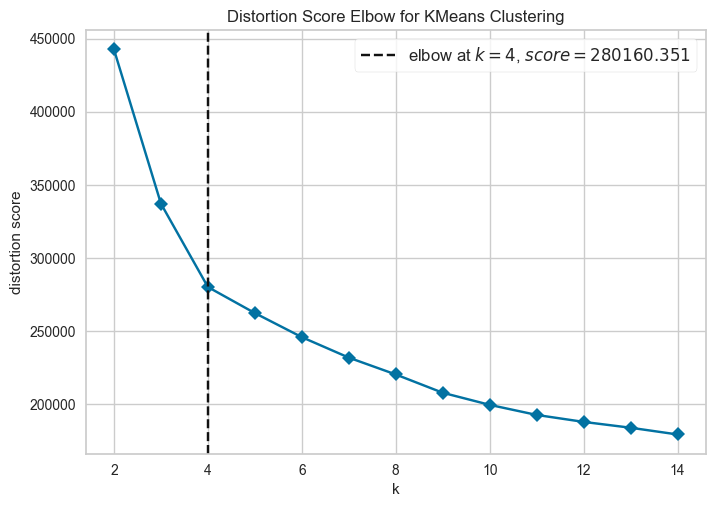

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
## Method 2: Instantiate the clustering model and visualizer for selecting the optimal k value
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='distortion', timings=False
)
visualizer.fit(X) 
visualizer.show() 

I refer to [this web for silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

## Hierarchical Clustering
* Agglomerative clustering
* [Sklearn document about clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0,linkage="complete", affinity="cosine",n_clusters=None)
model = model.fit(X)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


model = AgglomerativeClustering( linkage="complete", affinity="cosine",n_clusters=2)

y_pred = model.fit_predict(X)
print("purity_score: %0.3f" % purity_score(y, y_pred))

Another family of clustering algorithms is the visualized clustering, e.g., [VAT, iVAT](https://medium.com/analytics-vidhya/using-visualization-algorithms-vat-ivat-to-assess-cluster-tendency-a89251a2400e#:~:text=iVAT%20is%20a%20visual%20method%20of%20assessing%20the,clearer%20densely%20black%20squares%2Frectangles%20in%20its%20printed%20map.)

## Pass Activity

In [1]:
# Q1: Load data from digitData2.csv" file. The last column of each file presents the label and rest of the columns are features. 
df = pd.read_csv("data/digitData2.csv", header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]



NameError: name 'pd' is not defined

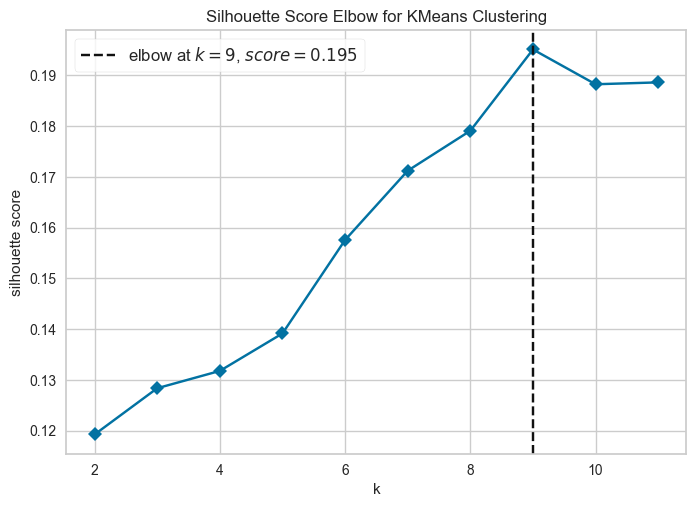

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [4]:
# Q1: Load data from digitData2.csv" file. The last column of each file presents the label and rest of the columns are features. 
df = pd.read_csv("data/digitData2.csv", header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]



# Q2: Selecting the optimum k value using Silhouette Coefficient and plot the optimum k values. 
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette', timings=False
) #distortion same as Euclidean distance

visualizer.fit(X)   # Fit the data to the visualizer
visualizer.show()


In [32]:
# Q1: Load data from digitData2.csv" file. The last column of each file presents the label and rest of the columns are features. 
df = pd.read_csv("data/digitData2.csv", header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]



# Q2: Selecting the optimum k value using Silhouette Coefficient and plot the optimum k values. 
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette', timings=False
) #distortion same as Euclidean distance

visualizer.fit(X)   # Fit the data to the visualizer
visualizer.show()


# Q3: Create clusters using Kmeans and Kmeans++ algorithms with optimal k value found in the previous problem. Report performances using appropriate evaluation metrics. Compare the results. 
model = KMeans(n_clusters=9, init="random")
y_pred=model.fit_predict(X)
print(f"Purity score: {purity_score(y, y_pred)}")
print(f"Silhouette score: {metrics.silhouette_score(X, y_pred)}")
print(f"Adjusted Rand index for K-Means performance: {metrics.adjusted_rand_score(y, y_pred)}")
print(f"Normalized mutual information for K-Means performance: {metrics.normalized_mutual_info_score(y, y_pred)}")

Purity score: 0.7369109947643979
Silhouette score: 0.19521352474987477
Adjusted Rand index for K-Means performance: 0.6015873907115012
Normalized mutual information for K-Means performance: 0.7376713809471297


In [34]:
# Q1: Load data from digitData2.csv" file. The last column of each file presents the label and rest of the columns are features. 
df = pd.read_csv("data/digitData2.csv", header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]



# Q2: Selecting the optimum k value using Silhouette Coefficient and plot the optimum k values. 
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette', timings=False
) #distortion same as Euclidean distance

visualizer.fit(X)   # Fit the data to the visualizer
visualizer.show()


# Q3: Create clusters using Kmeans and Kmeans++ algorithms with optimal k value found in the previous problem. Report performances using appropriate evaluation metrics. Compare the results. 
model = KMeans(n_clusters=9, init="random")
y_pred=model.fit_predict(X)
print(f"Purity score: {purity_score(y, y_pred)}")
print(f"Silhouette score: {metrics.silhouette_score(X, y_pred)}")
print(f"Adjusted Rand index for K-Means performance: {metrics.adjusted_rand_score(y, y_pred)}")
print(f"Normalized mutual information for K-Means performance: {metrics.normalized_mutual_info_score(y, y_pred)}")



model = KMeans(n_clusters=9, init="k-means++")
y_pred=model.fit_predict(X)
print(f"Purity score: {purity_score(y, y_pred)}")
print(f"Silhouette score: {metrics.silhouette_score(X, y_pred)}")
print(f"Adjusted Rand index for K-Means performance: {metrics.adjusted_rand_score(y, y_pred)}")
print(f"Normalized mutual information for K-Means performance: {metrics.normalized_mutual_info_score(y, y_pred)}")


# Q4:Now repeat clustering using Kmeans for 50 times and report the average performance.  Again compare the results that you have obtained in Q3 using Kmeans++ and explain the difference (if any).
purity_scores = []
silhouette_scores = []
ari_scores = []
nmi_scores = []
num_iters = 50
for _ in range(num_iters):
    model = KMeans(n_clusters=9, init="random")
    y_pred=model.fit_predict(X)
    purity_scores.append( purity_score(y, y_pred))
    silhouette_scores.append( metrics.silhouette_score(X, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")


silhouette_scores = []
purity_scores = []
ari_scores = []
nmi_scores = []
for _ in range(50): # or use the n_init=50 parameter
    model = KMeans(n_clusters=9, init="k-means++")
    y_pred=model.fit_predict(X)
    
    silhouette_scores.append(metrics.silhouette_score(X, y_pred))
    purity_scores.append( purity_score(y, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")

Purity score: 0.7362565445026178
Silhouette score: 0.19508735589363918
Adjusted Rand index for K-Means performance: 0.6009621580811086
Normalized mutual information for K-Means performance: 0.7354479507136964


In [5]:
# Q4:Now repeat clustering using Kmeans for 50 times and report the average performance.  Again compare the results that you have obtained in Q3 using Kmeans++ and explain the difference (if any).
purity_scores = []
silhouette_scores = []
ari_scores = []
nmi_scores = []
num_iters = 50
for _ in range(num_iters):
    model = KMeans(n_clusters=9, init="random")
    y_pred=model.fit_predict(X)
    purity_scores.append( purity_score(y, y_pred))
    silhouette_scores.append( metrics.silhouette_score(X, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")

Average purity score: 0.7369633507853404
Average silhouette score: 0.19510513701669424
Average adjusted Rand index score for K-Means over 50 runs: 0.6020233877765854
Average normalized mutual information score for K-Means over  ru50ns: 0.7374316529920237


In [6]:
silhouette_scores = []
purity_scores = []
ari_scores = []
nmi_scores = []
for _ in range(50): # or use the n_init=50 parameter
    model = KMeans(n_clusters=9, init="k-means++")
    y_pred=model.fit_predict(X)
    
    silhouette_scores.append(metrics.silhouette_score(X, y_pred))
    purity_scores.append( purity_score(y, y_pred))
    ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
    nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

print(f"Average purity score: {sum(purity_scores) / num_iters }")
print(f"Average silhouette score: {sum(silhouette_scores) / num_iters}")
print(f"Average adjusted Rand index score for K-Means over 50 runs: {sum(ari_scores) / num_iters}")
print(f"Average normalized mutual information score for K-Means over  ru50ns: {sum(nmi_scores) / num_iters}")

Average purity score: 0.738625654450262
Average silhouette score: 0.19476201117696515
Average adjusted Rand index score for K-Means over 50 runs: 0.6042575018050854
Average normalized mutual information score for K-Means over  ru50ns: 0.7384971443241504


DB-SCAN (Density-Based Spatial Clustering of Applications with Noise)
* Two Parameters
* Core points, border points and noise
* Unlike kmeans, it does not presume spherical clusters (may not have >=2 dense clusters) and demand that the number of
clusters be predetermined
* kmeans may not be able to detect overlapped or asymmetric groups, DBSCAN can.


In [ ]:
# Q5: Apply DBSCAN on this dataset (digitData2.csv) and find the optimum "eps" and "min_samples" value. 
# Is the number of cluster same as the cluster found in Q2? 
# Explain the similarity or differences that you have found between two solutions. 


Nearest neighbors

In [83]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

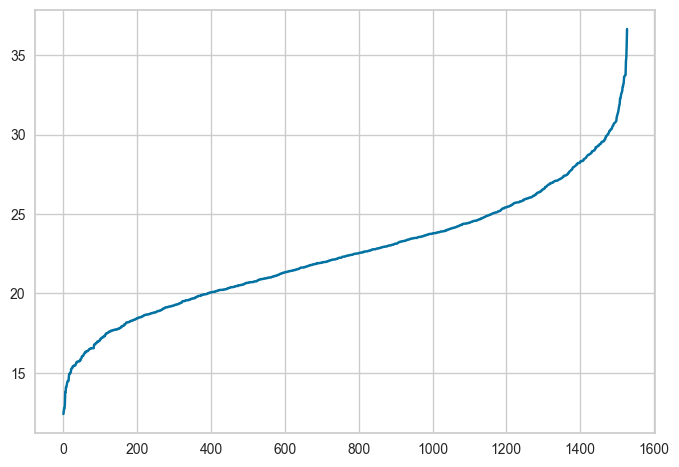

In [108]:
# for all the points, we calculate the distance to the nearest point  
neigh = NearestNeighbors(n_neighbors=9,  algorithm="auto")
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances[:,-1]) 
plt.plot(distances)
plt.show()

# How to choose K?
# K=9
# the submission from Alen Joseph Ben uses KNN to determine n_neighbors
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# k_range = list(range(1, 21))

# cv_scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())
#     print("k = %d, accuracy = %0.3f" % (k, scores.mean()))
# # Print the best value of k
# best_k = k_range[cv_scores.index(max(cv_scores))]
# print("Best k: %d" % best_k)
# # Final evaluation
# final_knn = KNeighborsClassifier(n_neighbors=best_k)
# final_knn.fit(X_train, y_train)
# final_score = final_knn.score(X_val, y_val)
# print(final_score)

In [109]:
distances[30]


15.459624833740307

In [ ]:
# Find optimum min_samples using k-distance graph
# min_samples is the minimum number of points that must be within 'eps' distance of a core point in order for it to be considered as a cluster which is known as the k-distance graph
#The value of k is set to 2 indicating that we are using the second knee point on the elbow plot to determine the value of min_samples
k = 2
k_distance = distances[::-1][k-1]
#Finding 10 nearest neighbors of each data point
neigh = NearestNeighbors(n_neighbors=10)
#Fits the data X to the NearestNeighbors object
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
distances = np.array([d[-1] for d in distances])
distances.sort()
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distances')
plt.title('K-Distance Graph')
plt.show()
#Calculateing the min_samples
min_samples = np.where(distances > k_distance)[0][0]

Why do we select the point at the maximum curvation?

Grid Search

In [94]:
silhouette_scores = []
purity_scores = []
ari_scores = []
nmi_scores = []
df_unique_labels = pd.DataFrame({"eps": [], "min_samples": [], "num_labels": []})

for eps in range(10, 35):
    for min_samples in range(1, 25):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        labelsData = dbscan.labels_
        unique_label_num = len(set(labelsData))
        df_unique_labels = df_unique_labels.append({"eps": eps, "min_samples": min_samples, "num_labels": unique_label_num }, ignore_index=True)
        if unique_label_num > 1 & unique_label_num < len(X):
            # print("labels:", unique_label_num, "eps:", eps, "min_samples:", min_samples)
            try:
                score = metrics.silhouette_score(X, labelsData)
                
            except ValueError:
                raise
            silhouette_scores.append((score, eps, min_samples, unique_label_num,labelsData))
            purity_scores.append( (purity_score(y, y_pred), eps, min_samples, unique_label_num,labelsData) )
            ari_scores.append(metrics.adjusted_rand_score(y, y_pred))
            nmi_scores.append(metrics.normalized_mutual_info_score(y, y_pred))

max_silhouette_score, optimal_eps, optimal_min_samples, optimal_n_label, y_pred = max(silhouette_scores)[:]
print(f"the max silhouette score: {max_silhouette_score}")
print(f"Optimal eps: {optimal_eps}; Optimal min_samples: {optimal_min_samples}; optimal number of cluster: {optimal_n_label}")
print(f"Adjusted Rand index for DBSCAN performance: {metrics.adjusted_rand_score(y, y_pred)}")
print(f"Normalized mutual information for DBSCAN performance: {metrics.normalized_mutual_info_score(y, y_pred)}")
print("the ground truth of labels :", len(set(y)), "the labels_pre: ", len(set(y_pred)))
print("\n")

max_purity_score, optimal_eps, optimal_min_samples, optimal_n_label, y_pred = max(purity_scores)[:]
print(f"the max purity score: {max_silhouette_score}")
print(f"Optimal eps: {optimal_eps}; Optimal min_samples: {optimal_min_samples}; optimal number of cluster: {optimal_n_label}")
print(f"Adjusted Rand index for DBSCAN performance: {metrics.adjusted_rand_score(y, y_pred)}")
print(f"Normalized mutual information for DBSCAN performance: {metrics.normalized_mutual_info_score(y, y_pred)}")
print("the ground truth of labels :", len(set(y)), "the labels_pre: ", len(set(y_pred)))
print("\n")


the max silhouette score: 0.14911176266271708
Optimal eps: 25; Optimal min_samples: 20; optimal number of cluster: 11
Adjusted Rand index for DBSCAN performance: 0.5235916139024015
Normalized mutual information for DBSCAN performance: 0.7165588044491888
the ground truth of labels : 10 the labels_pre:  11


the max purity score: 0.14911176266271708
Optimal eps: 32; Optimal min_samples: 24; optimal number of cluster: 2
Adjusted Rand index for DBSCAN performance: 3.6749544800371906e-05
Normalized mutual information for DBSCAN performance: 0.003995386941039195
the ground truth of labels : 10 the labels_pre:  2




In [110]:
dbscan = DBSCAN(eps=15.459, min_samples=5)
dbscan.fit(X)
labelsData = dbscan.labels_
df_unique_labels = df_unique_labels.append({"eps": eps, "min_samples": min_samples, "num_labels": len(np.unique(labelsData)) }, ignore_index=True)
unique_label_num = len(set(labelsData))
print(labelsData)
if unique_label_num > 1 & unique_label_num < len(X):
    print(metrics.silhouette_score(X, labelsData))
    print(purity_score(y, labelsData))
    n_noise = list(labelsData).count(-1)
    print(f"Number of clusters found by DBSCAN: {unique_label_num}")
    print(f"Number of noise points found by DBSCAN: {n_noise}")
        

[ 0 -1 -1 ... 10 -1 19]
-0.22159583370444244
0.27945026178010474
Number of clusters found by DBSCAN: 22
Number of noise points found by DBSCAN: 1255


In [115]:
dbscan = DBSCAN(eps=32.23, min_samples=X.shape[1] * 2)
dbscan.fit(X)
labelsData = dbscan.labels_
df_unique_labels = df_unique_labels.append({"eps": eps, "min_samples": min_samples, "num_labels": len(np.unique(labelsData)) }, ignore_index=True)
unique_label_num = len(set(labelsData))
print(labelsData)
if unique_label_num > 1 & unique_label_num < len(X):
    print(metrics.silhouette_score(X, labelsData))
    print(purity_score(y, labelsData))
    n_noise = list(labelsData).count(-1)
    print(f"Number of clusters found by DBSCAN: {unique_label_num}")
    print(f"Number of noise points found by DBSCAN: {n_noise}")
        


[ 0 -1 -1 ... -1 -1 -1]
0.0862670152973876
0.2931937172774869
Number of clusters found by DBSCAN: 3
Number of noise points found by DBSCAN: 792


Visualize how epsilon and min_samples affect the resulting number of clusters.

<Axes: xlabel='eps', ylabel='min_samples'>

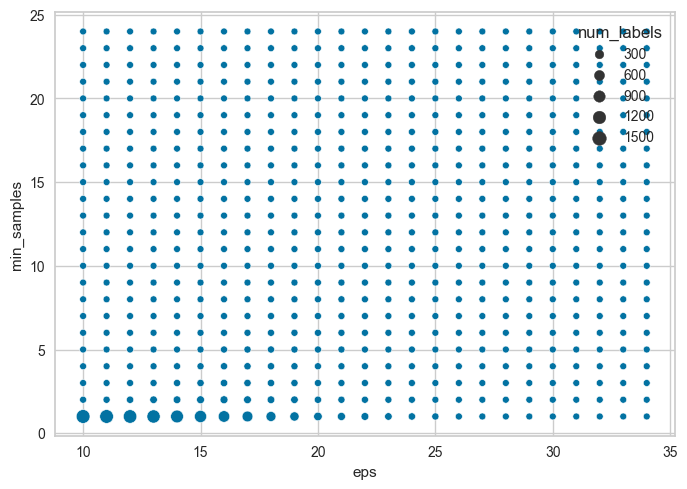

In [89]:
sns.scatterplot(data=df_unique_labels, x="eps", y="min_samples", size="num_labels")